In [1]:
from qiskit.circuit.library import QAOAAnsatz

import parity_network
import importlib
import numpy as np

In [5]:
num_qubits = 8

Parities and Weights of the Hamiltonian:
{'00100000': 0.3, '00000100': -0.2, '11000000': 0.4, '00010010': -0.1, '00001001': 0.25, '10101000': 0.5, '01010100': -0.3, '11000011': 0.6, '00111100': -0.4, '11111000': 0.7, '00011111': -0.5}

Forward Circuit with Rz gates:
                                                                     »
q_0: ───────■───────────────────────■─────────■───────────────────■──»
          ┌─┴─┐      ┌───────────┐  │       ┌─┴─┐               ┌─┴─┐»
q_1: ─────┤ X ├──────┤ Rz(0.8*γ) ├──┼───────┤ X ├──────────■────┤ X ├»
      ┌───┴───┴───┐  └───────────┘┌─┴─┐     └───┘          │    └───┘»
q_2: ─┤ Rz(0.6*γ) ├───────────────┤ X ├───────■────────────┼─────────»
      └───────────┘               └───┘       │          ┌─┴─┐       »
q_3: ──────────────────────■──────────────────┼──────────┤ X ├────■──»
                           │                ┌─┴─┐      ┌─┴───┴─┐  │  »
q_4: ──────────────────────┼────────■───────┤ X ├──────┤ Rz(γ) ├──┼──»
     ┌──────────────┐  

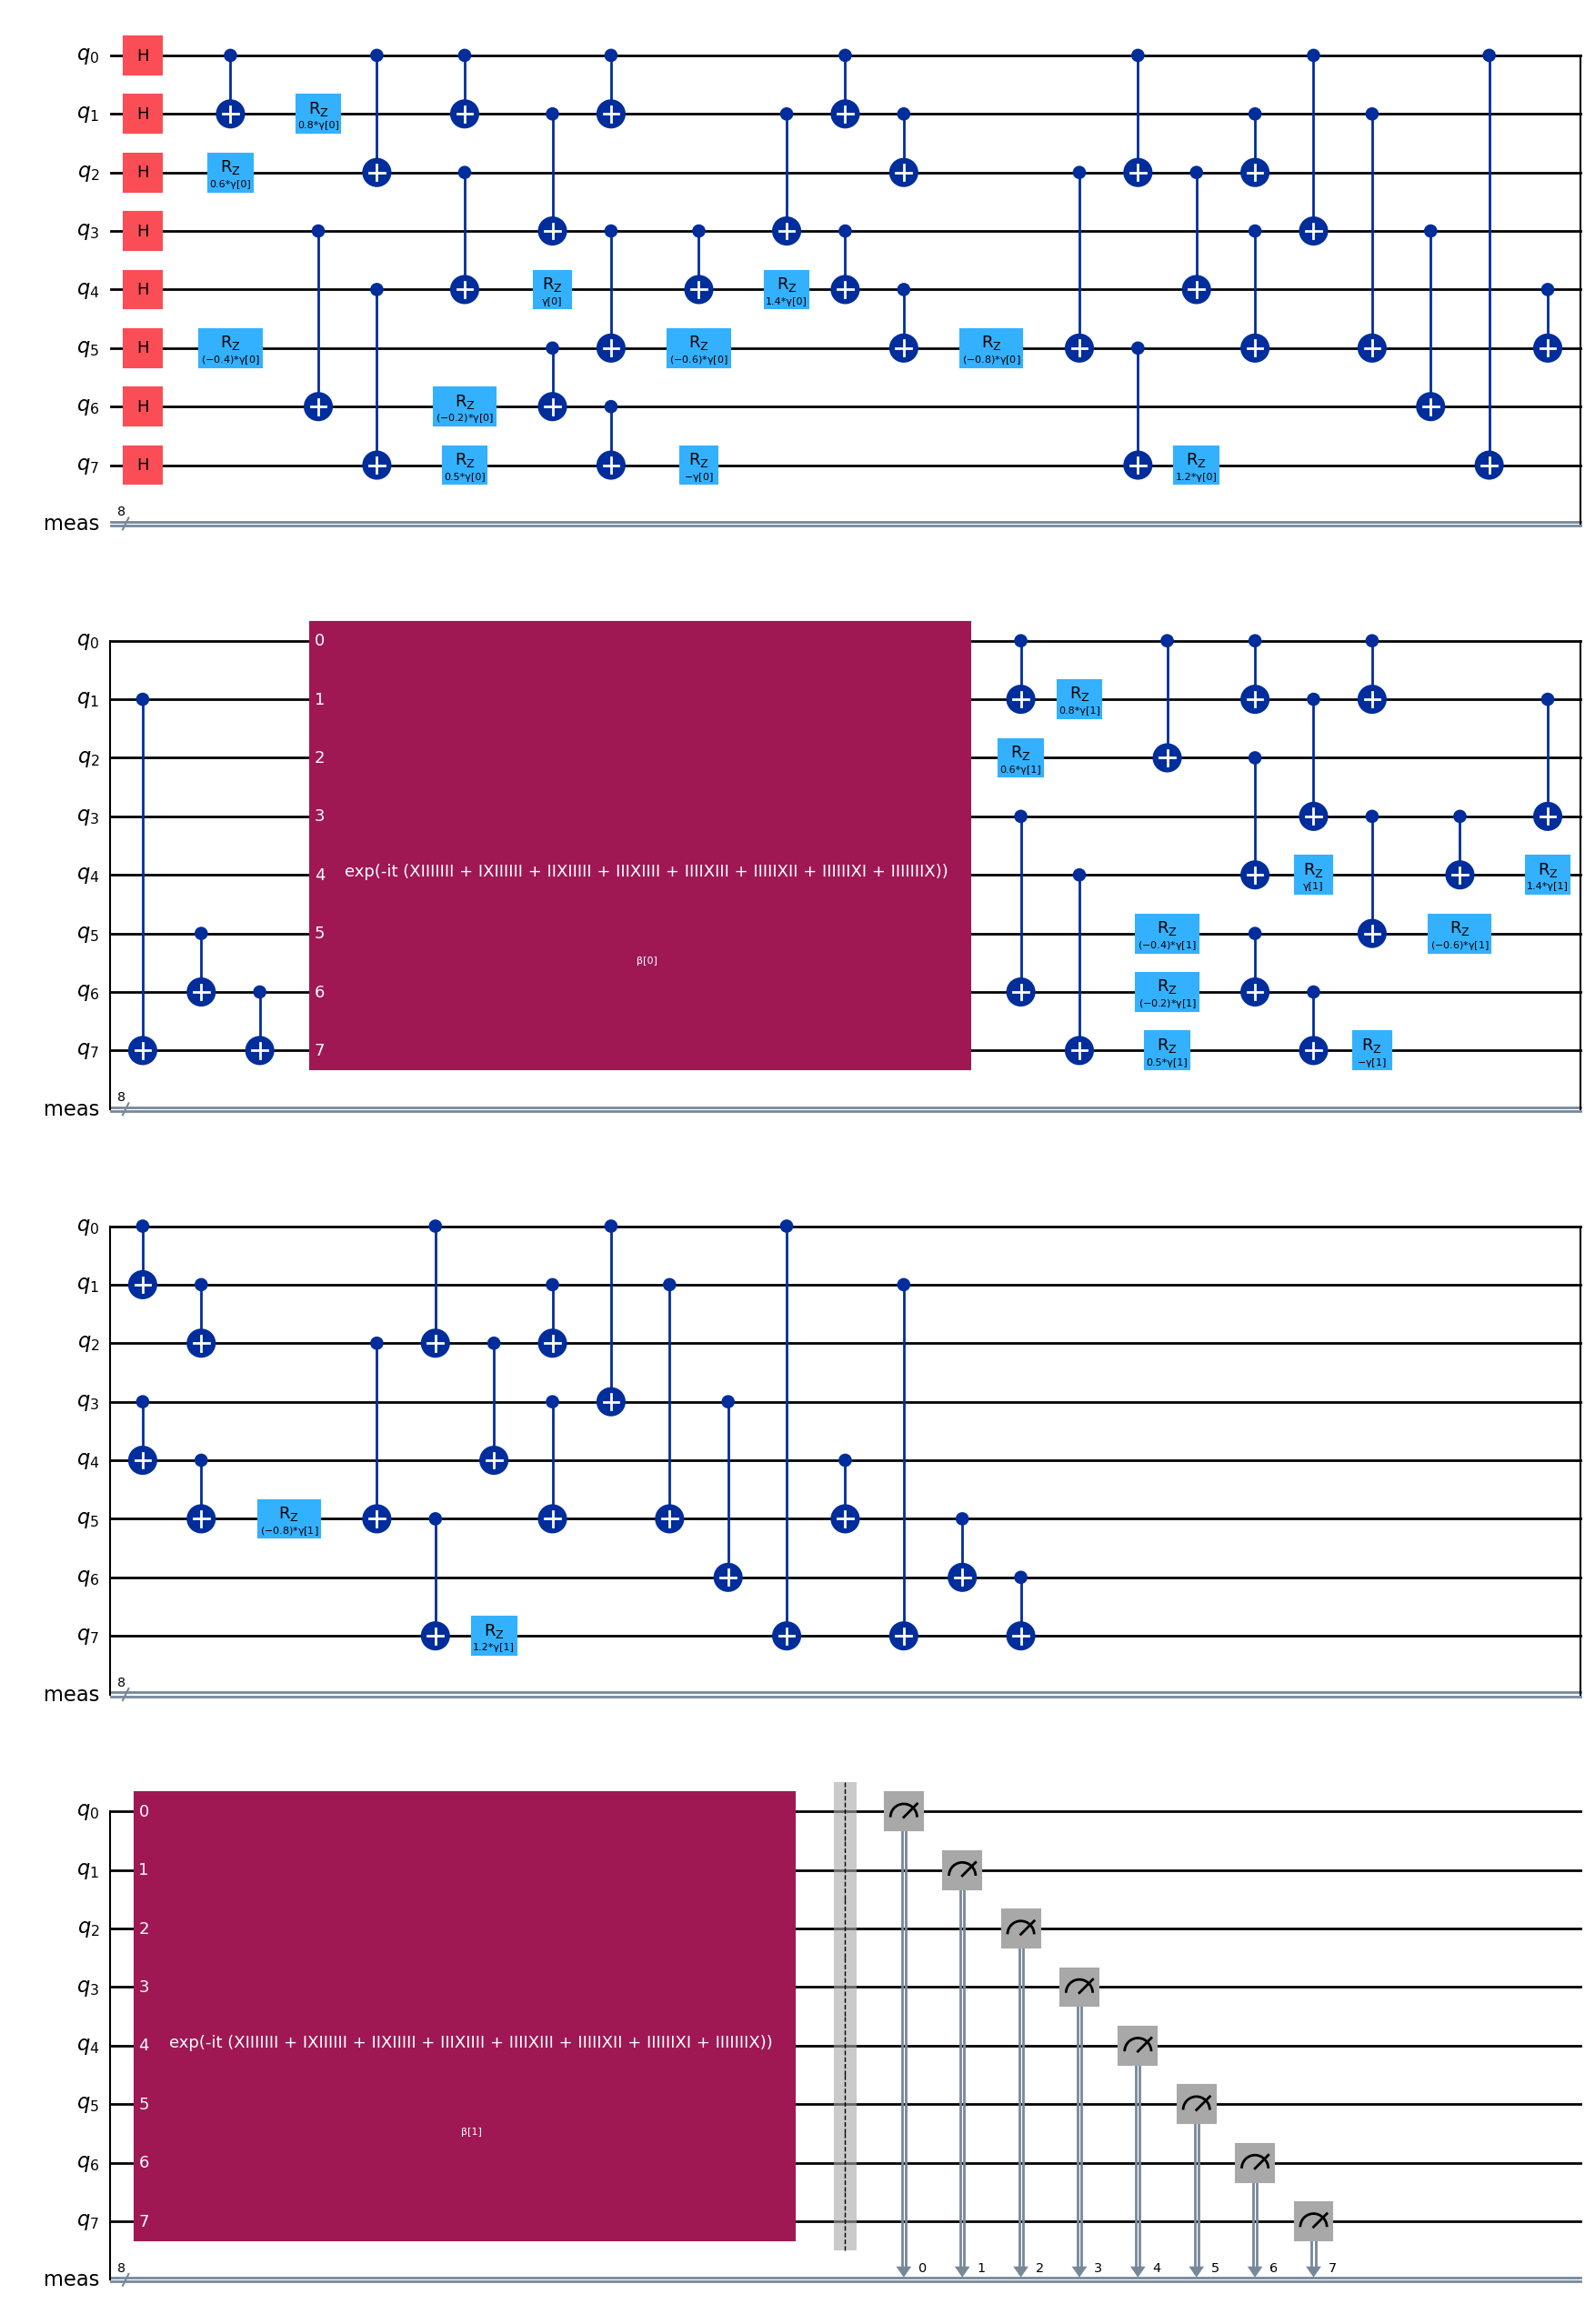

In [6]:
importlib.reload(parity_network)

parity, term_dict = parity_network.main(num_qubits)

parity_ansatz = QAOAAnsatz(parity, reps=2)
parity_ansatz.measure_all()

parity_ansatz.decompose().draw("mpl")

In [7]:
from qiskit.quantum_info import SparsePauliOp


def get_hamiltonian_observable(term_dict, n_qubits):
    """Converts a dictionary of bitstrings and weights into a Qiskit SparsePauliOp observable."""
    pauli_list = []
    coeff_list = []
    for bitstring, weight in term_dict.items():
        pauli_str = ["I"] * n_qubits
        for i, bit in enumerate(bitstring):
            if bit == "1":
                pauli_str[n_qubits - 1 - i] = "Z"
        pauli_list.append("".join(pauli_str))
        coeff_list.append(weight)

    return SparsePauliOp(pauli_list, coeffs=coeff_list)

In [8]:
from scipy.optimize import minimize
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2 as AerEstimator
from qiskit.compiler import transpile

backend = AerSimulator()
estimator = AerEstimator()
estimator.options.shots = 10000

parity_ansatz_isa = transpile(parity_ansatz, backend=backend)

obs = get_hamiltonian_observable(term_dict, num_qubits)
print(obs)

SparsePauliOp(['IIIIIZII', 'IIZIIIII', 'IIIIIIZZ', 'IZIIZIII', 'ZIIZIIII', 'IIIZIZIZ', 'IIZIZIZI', 'ZZIIIIZZ', 'IIZZZZII', 'IIIZZZZZ', 'ZZZZZIII'],
              coeffs=[ 0.3 +0.j, -0.2 +0.j,  0.4 +0.j, -0.1 +0.j,  0.25+0.j,  0.5 +0.j,
 -0.3 +0.j,  0.6 +0.j, -0.4 +0.j,  0.7 +0.j, -0.5 +0.j])


In [9]:
parity_cost_history_dict = {
    "iters": 0,
    "cost_history": [],
}


def initialize_cost_history_dict(cost_history_dict):
    cost_history_dict["prev_vector"] = None
    cost_history_dict["iters"] = 0
    cost_history_dict["total_energy"] = []
    cost_history_dict["eigenstates_energies"] = [[] for _ in range(num_qubits)]

In [10]:
def cost_func_estimator(params, ansatz, hamiltonian, estimator, cost_history_dict):

    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)

    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    cost_history_dict["iters"] += 1
    cost_history_dict["cost_history"].append(cost)
    print(f"Iters {cost_history_dict['iters']}: Current cost: {cost}")

    return cost

In [11]:
params_init = np.random.rand(parity_ansatz_isa.num_parameters) * 2 * np.pi
initialize_cost_history_dict(parity_cost_history_dict)

result_parity = minimize(
    cost_func_estimator,
    params_init,
    args=(parity_ansatz_isa, obs, estimator, parity_cost_history_dict),
    method="COBYLA",
)

Iters 1: Current cost: -0.0002929687499999903
Iters 2: Current cost: 0.28027343749999994
Iters 3: Current cost: -0.153515625
Iters 4: Current cost: 0.17421874999999995
Iters 5: Current cost: -0.20937499999999998
Iters 6: Current cost: 0.030371093750000015
Iters 7: Current cost: 0.11484375
Iters 8: Current cost: -0.0990234375
Iters 9: Current cost: -0.06337890624999999
Iters 10: Current cost: -0.04072265624999999
Iters 11: Current cost: -0.14755859375000002
Iters 12: Current cost: -0.12041015624999998
Iters 13: Current cost: -0.11220703125
Iters 14: Current cost: -0.15468749999999998
Iters 15: Current cost: -0.19423828124999998
Iters 16: Current cost: -0.16826171875
Iters 17: Current cost: -0.16220703125
Iters 18: Current cost: -0.15273437499999998
Iters 19: Current cost: -0.15341796875000002
Iters 20: Current cost: -0.13300781249999996
Iters 21: Current cost: -0.1650390625
Iters 22: Current cost: -0.20771484375
Iters 23: Current cost: -0.15615234374999998
Iters 24: Current cost: -0.196

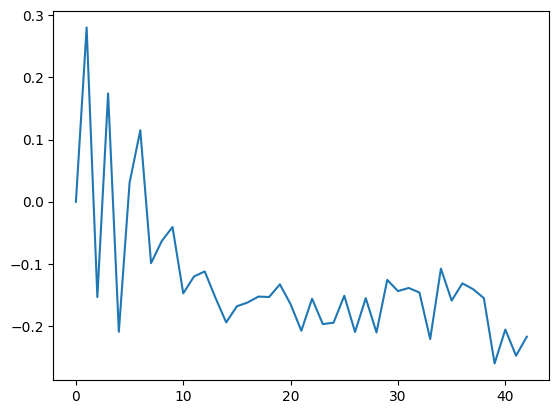

In [12]:
import matplotlib.pyplot as plt

plt.plot(parity_cost_history_dict["cost_history"])

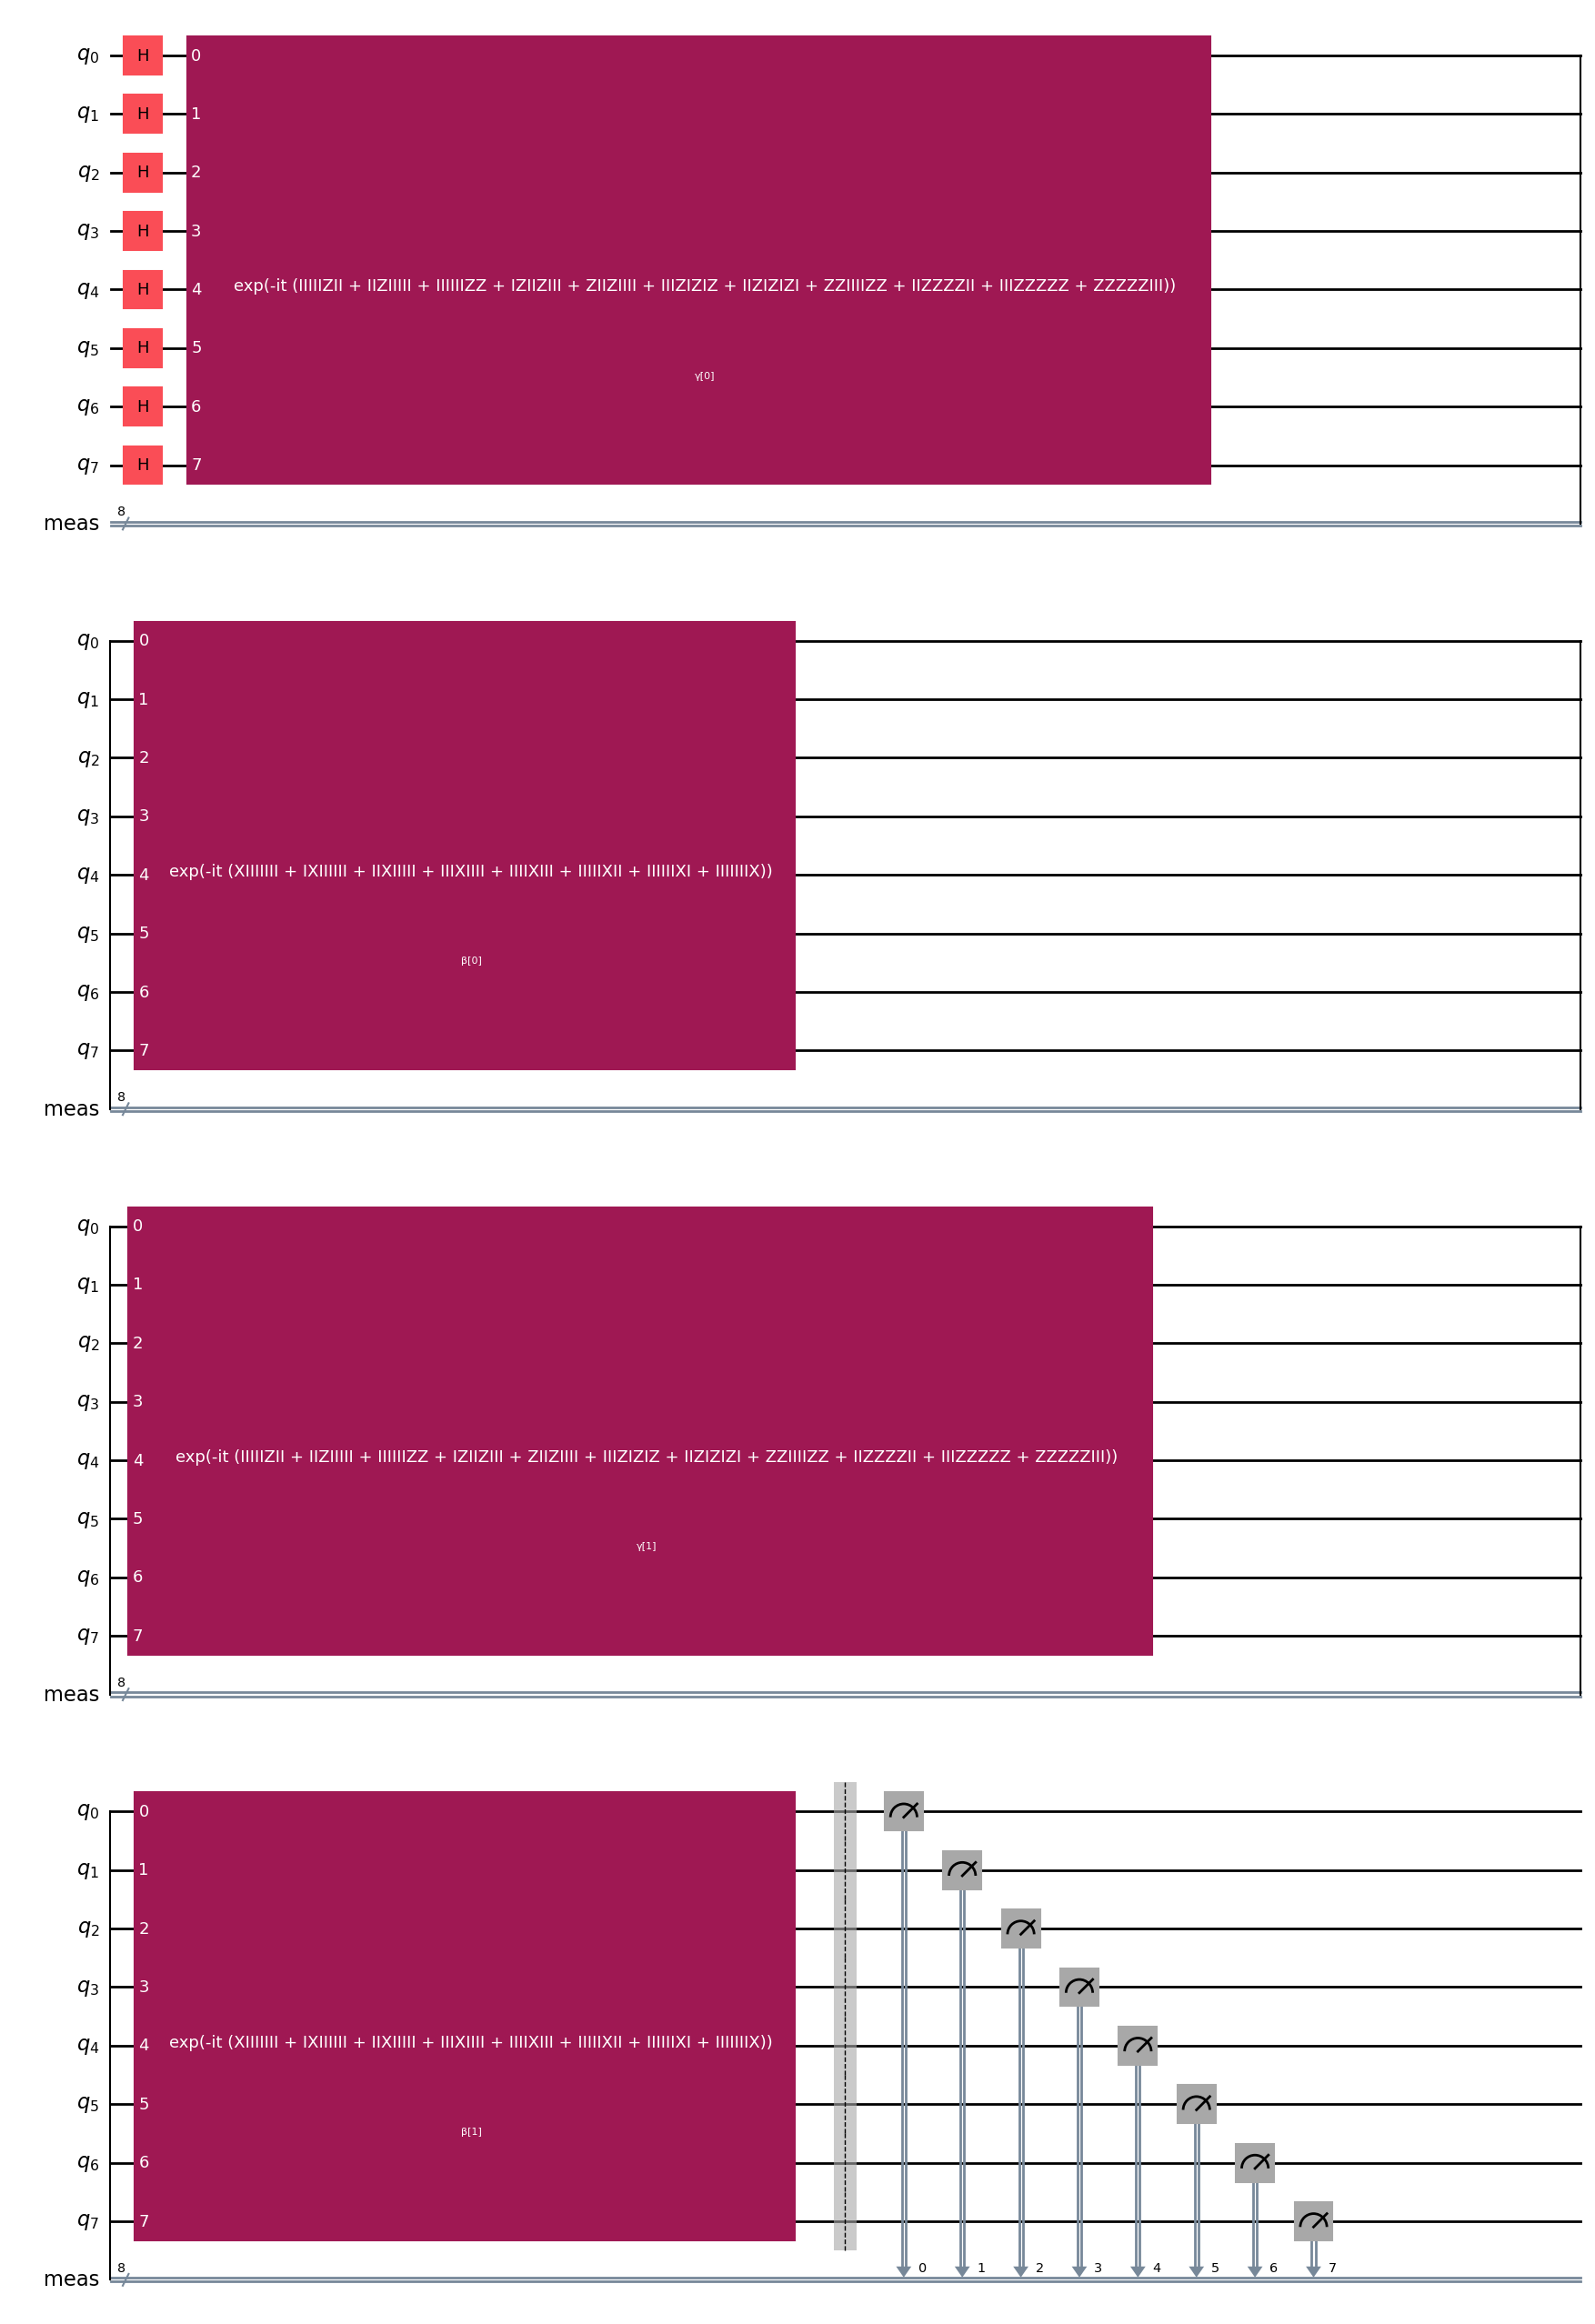

In [13]:
naive_ansatz = QAOAAnsatz(obs, reps=2)
naive_ansatz.measure_all()

naive_ansatz.decompose().draw("mpl")

In [14]:
naive_ansatz_isa = transpile(naive_ansatz, backend=backend)

In [15]:
naive_cost_history_dict = {
    "iters": 0,
    "cost_history": [],
}

In [16]:
params_init = np.random.rand(naive_ansatz_isa.num_parameters) * 2 * np.pi
initialize_cost_history_dict(naive_cost_history_dict)

result_naive = minimize(
    cost_func_estimator,
    params_init,
    args=(naive_ansatz_isa, obs, estimator, naive_cost_history_dict),
    method="COBYLA",
)

Iters 1: Current cost: 0.15634765625000002
Iters 2: Current cost: 0.04736328125000001
Iters 3: Current cost: 0.07607421874999999
Iters 4: Current cost: -0.08378906250000002
Iters 5: Current cost: -0.1482421875
Iters 6: Current cost: 0.5743164062499999
Iters 7: Current cost: -0.26904296875
Iters 8: Current cost: -0.039062499999999986
Iters 9: Current cost: -0.19267578124999998
Iters 10: Current cost: -0.104296875
Iters 11: Current cost: -0.27666015624999996
Iters 12: Current cost: -0.08330078124999997
Iters 13: Current cost: -0.15478515625
Iters 14: Current cost: -0.010058593750000025
Iters 15: Current cost: -0.41533203125000007
Iters 16: Current cost: -0.34033203125000006
Iters 17: Current cost: -0.38955078125
Iters 18: Current cost: -0.3228515625
Iters 19: Current cost: -0.3458984375
Iters 20: Current cost: -0.38046874999999997
Iters 21: Current cost: -0.3541015625
Iters 22: Current cost: -0.31230468750000007
Iters 23: Current cost: -0.34560546875
Iters 24: Current cost: -0.3725585937

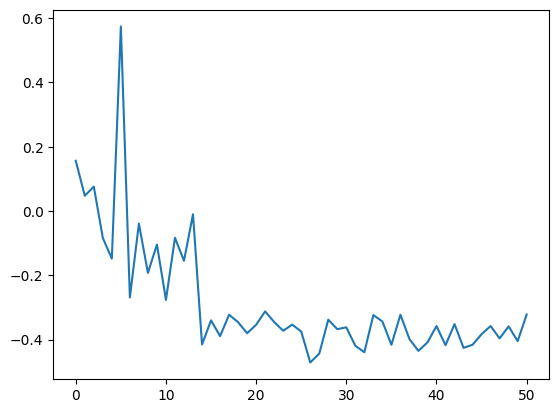

In [17]:
plt.plot(naive_cost_history_dict["cost_history"])